In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

Wavenet uses a heirarchical tree-like approach to predict the next character in a sequence

In [20]:
words = open("video_2_dependencies/names.txt").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {char: idx + 1 for idx, char in enumerate(chars)}
stoi['.'] = 0
itos = {idx: char for char, idx in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [21]:
import random
random.seed(42)
random.shuffle(words)

In [71]:
block_size = 8
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0]*block_size 
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [72]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [141]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2: #if normal 2D tensor  (batch, dim), then use dim = 0
        dim = 0
      elif x.ndim == 3: #if 3d tensor average over the two batch dimensions for each channel
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [135]:
torch.manual_seed(42) #Seed for reproducibility

In [139]:
n_embd = 10
n_hidden = 68 #Chanegd to 68 such that it has same num of parameters as previous models, to show that our progressive fusion approach utilizes the same amount of capacity better

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *=0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [144]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", layer.out.shape)

Embedding : torch.Size([32, 8, 10])
FlattenConsecutive : torch.Size([32, 4, 20])
Linear : torch.Size([32, 4, 68])
BatchNorm1d : torch.Size([32, 4, 68])
Tanh : torch.Size([32, 4, 68])
FlattenConsecutive : torch.Size([32, 2, 136])
Linear : torch.Size([32, 2, 68])
BatchNorm1d : torch.Size([32, 2, 68])
Tanh : torch.Size([32, 2, 68])
FlattenConsecutive : torch.Size([32, 136])
Linear : torch.Size([32, 68])
BatchNorm1d : torch.Size([32, 68])
Tanh : torch.Size([32, 68])
Linear : torch.Size([32, 27])


Note: Before we assumed X is 2D, we reduced mean and variance across the 0th dimension in batchnorm. However, now x is 3-Dim

To show what it is currently doing ...

In [145]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim = True) #1, 4, 68
evar = e.var(0, keepdim = True) #1, 4, 68 
ehat = (e - emean) / torch.sqrt(evar + 1e-5) #32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [ ]:
#Wrong batchnrom gives ... 
#model.layers[3].running_mean.shape

#(1,4,68), but we want only 68 means and variances, 1 for each chanell 

#Instead at the moment, we are maintaining statistics for each of these 4 positions independet;y, and instead what we want to do, is to treate
#these 4 also as a batch dimension. So, w.r.t to batchnorm, we do not want to average only the normal BATCH dimension (i.e 32) but instead (32 x4) numbers for every
#one of these 68 channels. this ensures that the measurements for meana nd variance are more stable, as using 32*4 numbers to generate these statistics rather then just 32 numbers if batchnorm implementation was left alone

In [146]:
#Now only maintaining 68 means and vars after fixing batchnorm
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [140]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())


      0/ 200000: 3.3038
  10000/ 200000: 2.1296
  20000/ 200000: 2.0379


KeyboardInterrupt: 

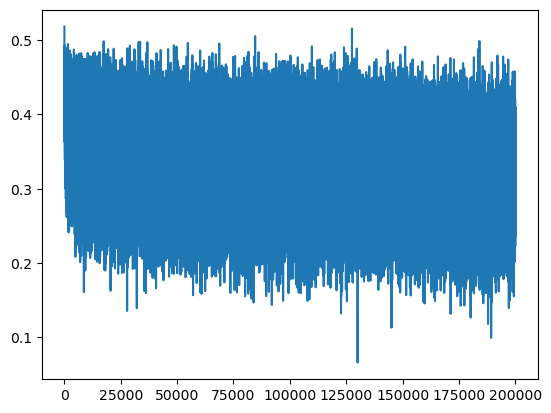

In [38]:
plt.plot(lossi)

In [ ]:
#Because the batches are so small, lots of noise in the plot, compute the mean of these batch losses over N iterations, and plot the means

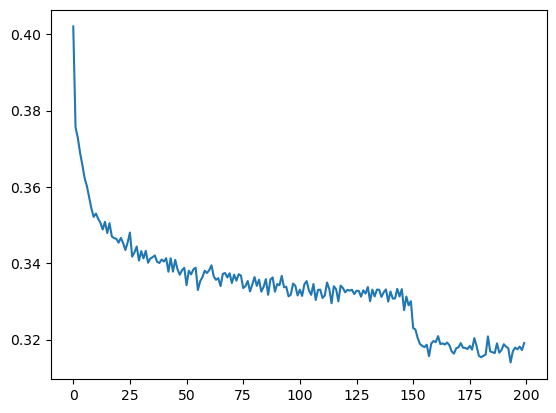

In [43]:
plt.plot(torch.mean(torch.tensor(lossi).view(200, -1), 1))

Now we can see the progress better, specifically at 150, after applying LR decay, it subtracted alot of energy out of the system and allowed for it to settle in the local min in this optimization

In [64]:
# Put layers into eval model (needed for batchnorm esp.)
for layer in model.layers:
    layer.training = False

In [79]:
@torch.no_grad() #Disables gradient tracking for the function defined below
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 1.916096568107605
val 2.030439853668213


Because the losses are so similiar, we have a sense that we are not overfitting and can make additional progress, by scaling up the size of the NN (bigger and deeper)


Our current implementation of 3 chars, 3 char embeddings, concat and passed into single linear layer, in a sense crushes all the characters at the beginning, and even if we make it a bigger layer, it is silly to squash all that information so fast in a single step

Instead use wavenet, where prediction of next char is depeendent not only on the previous chars which are fed in but these chars are not crushed immediately into a single layer, but are instead crushed slowly.
In particular, take two characters and fuse them into a bigram representation and we do that for all chars consecutively, in which the following layer, take the bigram representations, fuse those into four charcter level of chunks. Continue to do so in a tree like heirarchical manner until prediction 

Main ideas: Deeper Network + Progressive Fusion (at each level, fuse two consective elements (2 bigrams, then 2 fourgram, etc...) )

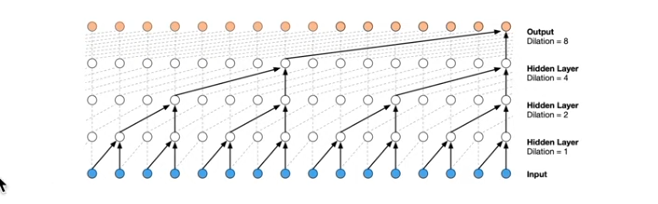

In [66]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word



ima.
aavin.
malaella.
saxel.
jim.
aminh.
fak.
callynn.
dhal.
tarlyn.
para.
adwjlanna.
amishimakkishmanotton.
aziya.
leyah.
kallan.
samy.
old.
jarland.
esgen.


If increase context size to 8, and rerun baseline model (which crushes all the information too quickly), we do get some improvment just from pure context

In [83]:
(torch.randn(4,5,2,80) @ torch.randn(80, 200)).shape

#Can see with torch matrix multiplication only last-D of first matrix of D dims needs to match first-D of second matrix  
#The remaining D's of the first matrix will remain the same (treated as batch dimensions)
#Thus in parallel over all batch dimensions, can do matrix multiplication over on the last dimension

torch.Size([4, 5, 2, 200])

In [85]:
#We do not want to flatten 1 2 3 4 5 6 7 8 and pass to linear layer
#Instead we want to process these consectuve elements as (1 2) (3 4) (5 6) (7 8), flatten out, and multiply by weight matrix in parallel
#Remember embedding dim = 10 for eaqh char...
(torch.randn(4,4,20) @ torch.randn(20, 200) + torch.rand(200)).shape

torch.Size([4, 4, 200])

In [94]:
e = torch.randn(4, 8, 10)
e[:, ::2, :] ##::N indexes in step of N; gives all the even characters
e[:, 1::2, :] #gives all the odd characters
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim = 2)
explicit.shape

torch.Size([4, 4, 20])

In [96]:
#Could also do via view 
(e.view(4,4,20) == explicit).all()

tensor(True)

In [ ]:
#Good idea to test out shapes in Jupyter Notebook, then use VSCODE 